# GoBike Share Usage Pattern Analysis 
## by Jihye Seo

## Preliminary Wrangling

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.


In [1]:
!pip install haversine

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from haversine import haversine, Unit

%matplotlib inline

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [3]:
df=pd.read_csv("201902-fordgobike-tripdata.csv")
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [5]:
#Drop rows with null values
df.dropna(inplace=True)

In [6]:
##check for duplicated rows
df[df.duplicated()==True]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip


In [7]:
df.reset_index(inplace=True,drop=True)

In [8]:
#Create Age column based on member_birth_year column
df['member_birth_year']=df['member_birth_year'].astype('int')
df['age']=2021-df['member_birth_year']

#TEST
df[['member_birth_year','age']].sample(10)

,member_birth_year,age
62477,1988,33
80680,1993,28
145888,1971,50
51580,1993,28
81358,1973,48
161880,1975,46
44454,1987,34
35891,1964,57
113785,1996,25
172669,1983,38


In [9]:
#convert timestamp to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
#extract year, month, day, hour to new columns
df['year'] = df['start_time'].dt.year
df['month'] = df['start_time'].dt.month
df['day'] = df['start_time'].dt.day
df['hour']= df['start_time'].dt.hour
#extract day of week from start time
df['weekday']=df['start_time'].dt.weekday


In [10]:
weekdays = ['Mon','Tue','Wed','Thu','Fri', 'Sat', 'Sun']
for i in range(0,7):
    df.loc[df.weekday==i,'weekday']=weekdays[i]
#df["weekday"]=df["weekday"].astype("category")

In [11]:
weekdays = ['Mon','Tue','Wed','Thu','Fri', 'Sat', 'Sun']
ordered_weekdays = pd.api.types.CategoricalDtype(ordered = True, categories = weekdays)
df['weekday'] = df['weekday'].astype(ordered_weekdays)

In [12]:
df['is_weekend']=0
df.loc[df.weekday=='Sat','is_weekend']=1
df.loc[df.weekday=='Sun','is_weekend']=1
df[['weekday','is_weekend']].sample(5)

,weekday,is_weekend
48650,Thu,0
64736,Wed,0
126376,Sat,1
108881,Tue,0
64830,Wed,0


In [13]:
#Test: check year,month,day and weekday with original start_time
df[['start_time','year','month','day','hour','weekday']].sample(5)
## 2019-02-28 is thursday. Mon->Sun is 0->6  

,start_time,year,month,day,hour,weekday
48101,2019-02-21 19:27:27.490,2019,2,21,19,Thu
98061,2019-02-14 15:41:20.208,2019,2,14,15,Thu
147453,2019-02-06 09:36:47.144,2019,2,6,9,Wed
67116,2019-02-19 18:23:21.367,2019,2,19,18,Tue
159017,2019-02-04 18:28:04.470,2019,2,4,18,Mon


In [14]:
# Convert duration in seconds to ducation in minutes
df['duration_min']=df['duration_sec']/60

In [15]:
# Calculate distance between start station and end station
start=list(zip(df['start_station_latitude'],df['start_station_longitude']))
end=list(zip(df['end_station_latitude'],df['end_station_longitude']))
df['dist']=list(map(haversine, start,end))
df['oneway_trip']=1
df.loc[df.dist==0,'oneway_trip']=0
df.groupby('oneway_trip')['oneway_trip'].count()

oneway_trip
0      3458
1    171494
Name: oneway_trip, dtype: int64

In [16]:

#Change station id types to string
df['start_station_id']=df['start_station_id'].astype('int')
df['end_station_id']=df['end_station_id'].astype('int')
df['start_station_id']=df['start_station_id'].astype('category')
df['end_station_id']=df['end_station_id'].astype('category')
#TEST: Check datatypes for each column
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174952 entries, 0 to 174951
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_id         174952 non-null  category      
 4   start_station_name       174952 non-null  object        
 5   start_station_latitude   174952 non-null  float64       
 6   start_station_longitude  174952 non-null  float64       
 7   end_station_id           174952 non-null  category      
 8   end_station_name         174952 non-null  object        
 9   end_station_latitude     174952 non-null  float64       
 10  end_station_longitude    174952 non-null  float64       
 11  bike_id                  174952 non-null  int64         
 12  user_type       

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174952 entries, 0 to 174951
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_id         174952 non-null  category      
 4   start_station_name       174952 non-null  object        
 5   start_station_latitude   174952 non-null  float64       
 6   start_station_longitude  174952 non-null  float64       
 7   end_station_id           174952 non-null  category      
 8   end_station_name         174952 non-null  object        
 9   end_station_latitude     174952 non-null  float64       
 10  end_station_longitude    174952 non-null  float64       
 11  bike_id                  174952 non-null  int64         
 12  user_type       

### What is the structure of your dataset?

> There are 26 columns(including which I have added)  and 174952 rows (after dropping rows with nulls)
- Bike Time & durations
    - Duration in seconds and minutes(duration_sec,duraction_min)
    - start/end time (start_time,end_time)
    - start time in Year/Month/Day/weekday/time (year,month,day,weekday,time)
- Start/End location 
    - Start/End station id  (start_station_id)             
    - start/End station name(start_station_name, end_station_name)
    - Start/End station latitude & logitude (start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitued)
- Bike Information
    - bike_id
- User Information
    - Subscriber or Customer(user_type)
    - member gender (member_gender)
    - age (member_birth_year,age)
- Bike share status
    - bike_share_for_all_trip

### What is/are the main feature(s) of interest in your dataset?

> I am interested in data that explains user profile and user behaviors. For examples, 
+ When are most trips taken in terms of time of day, day of the week. 
+ How long do bike trips take? and How are the duration of these bike trips distributed?
+ What are the chracteristic(age, gender,user type) of heavy bike users? 
+ How far apart from start and end station? Do users use this bike for round trip or one-way trip? 
+ Does the trip distance/duration depend on if a user is a subscriber or customer?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> - hour,weekday to see trip frequencies by day and weekday.
> - age, mamber_gender, user_type for user profile analysis
> - duration_sec,duration_min for bike duration frequencies
> - dist,duration_min to see if this bike is used for round trip or one-way trip.


## Univariate Exploration

>### 1.1 Bike usage by Hour
>I'll start by looking at frequency of bike trips by hour to see when the most trips are made in a day.

In [18]:
#plt.style.use("seaborn-darkgrid")

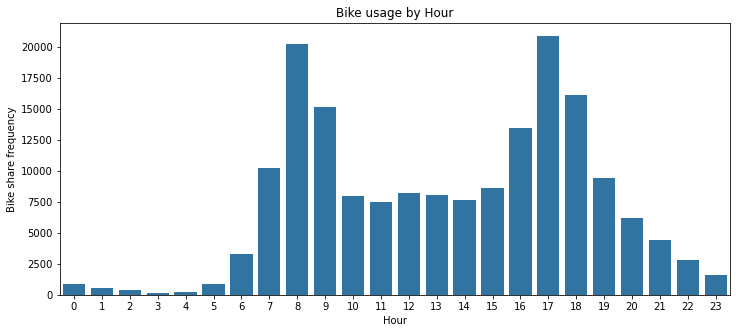

In [19]:
base_color = sb.color_palette()[0]
plt.figure(figsize=[12,5])
#plt.xticks(range(24))
sb.countplot(data=df,x='hour',color=base_color)
plt.xlabel('Hour')
plt.ylabel('Bike share frequency')
plt.title('Bike usage by Hour');

> A bimodal curve with peaks at 8 AM and 5 PM shows that  bike trip frequency is highest around commuting time.

> ### 1.2 Bike usage by Weekday
> I will also check out frequnecy of bike trips by weekday to see when is the most busy day of week. 

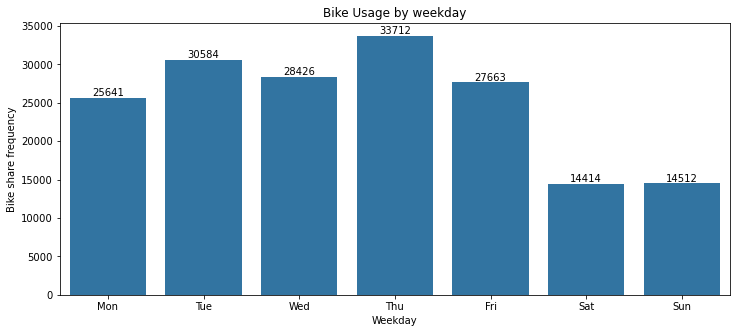

In [20]:
bins=np.arange(7)

plt.figure(figsize=[12,5])
sb.countplot(data=df,x='weekday',color=base_color)

plt.xlabel('Weekday')
plt.ylabel('Bike share frequency')
plt.title('Bike Usage by weekday')

weekday_freq=df.groupby('weekday').weekday.count()
for x,y in zip(bins,weekday_freq):
    label = "{}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,2), # distance from text to points (x,y)
                 ha='center') ;# horizontal alignment can be left, right or center


> This figure shows that the usage over weekdays is greater than over weekends(almost 1/3~1/2 of weekdays).

> ### 1.3 Distribution of the Age of Users
> Next, I will check out frequncy of bike share by different age groups.
> Since I have found that there were some unreasonable age groups(for example age >=90) I have limited my observation around 20s ~ 80s(exclusive). 

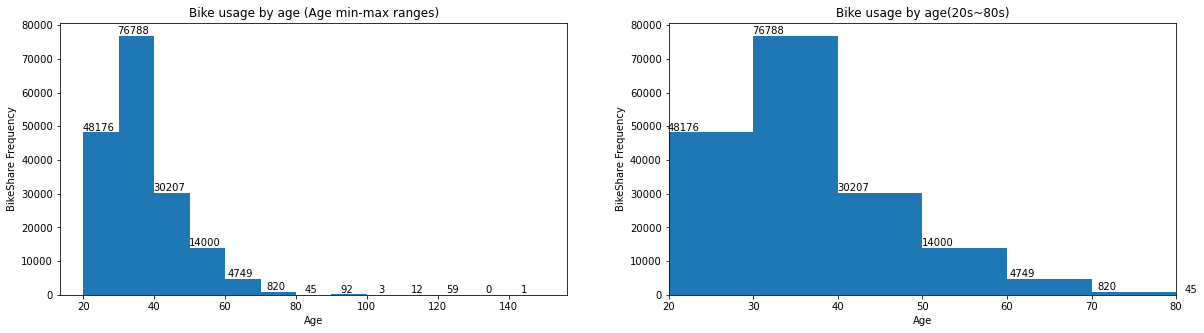

In [21]:
bins=np.arange(df.age.min(), df.age.max()+10,10)
age_cat_values=pd.cut(df.age,bins,right=False,include_lowest=True)
values=df.groupby(age_cat_values).age.count()
#print(values)

plt.figure(figsize=[20,5])
plt.subplot(1, 2, 1)
bins=np.arange(df.age.min(),df.age.max()+10,10)
plt.hist(data=df,x='age',bins=bins)
plt.ylabel('BikeShare Frequency')
plt.xlabel('Age')
plt.title('Bike usage by age (Age min-max ranges)')
for x,y in zip(bins,values[:]):

    label = "{}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(15,2), # distance from text to points (x,y)
                 ha='center') ;# horizontal alignment can be left, right or center

#### Limit by 80#######
plt.subplot(1, 2, 2)
plt.hist(data=df,x='age',bins=bins)
plt.ylabel('BikeShare Frequency')
plt.xlabel('Age')
plt.title('Bike usage by age(20s~80s)')



for x,y in zip(bins,values[:7]):

    label = "{}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(15,2), # distance from text to points (x,y)
                 ha='center') ;# horizontal alignment can be left, right or center
plt.xlim(20,80);

> Most frequent trips were made by users of age between 30~40s(exclusive). Since I don't have unique user id I have no clue that how many unique users are in this age group. If I have this, I could give more aspect of user profile (e.g average frequncy of trips by age group) 

> ### 1.4 Bike Usage by Gender
> Here I will check out the usage by different gender.

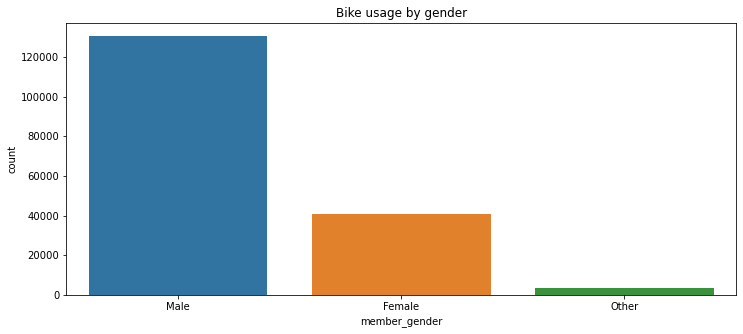

In [22]:
plt.figure(figsize=[12,5])

x_order=['Male','Female','Other']
sb.countplot(data=df,x='member_gender',order=x_order)
plt.title('Bike usage by gender');

> Most trips were made by Male user. Male trip count is roughly 3 times larger than female users.

> ### 1.5 Bike Usage by User Type
I will investigate usage (frequency of bike trips) by Subscribers vs. Non-sbuscribers.

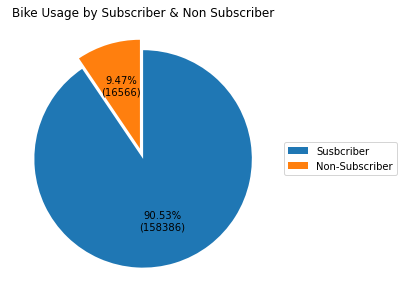

In [23]:
plt.figure(figsize=[12,5])
#x_order=['Subscriber','Customer']
x_label=['Susbcriber','Non-Subscriber']
explode = (0,0.1) 
#sb.countplot(data=df,x='user_type',order=x_order)
sorted_count=df['user_type'].value_counts()

#plt.pie(sorted_count,labels=sorted_count.index,startangle=90, explode=explode,autopct='%1.1f%%',counterclock=False)

plt.pie(sorted_count,labels=None,startangle=90, explode=explode,\
        autopct=lambda p:'{:.2f}%\n({:.0f})'.format(p,(p/100)*sorted_count.sum()),counterclock=False)

plt.title('Bike Usage by Subscriber & Non Subscriber')
plt.legend(x_label,bbox_to_anchor = (1, 0.5), loc = 6)
plt.axis('off');


> Usage by subcriber take almost 90.53% which reprsent that the usage by subcriber are more frequent (9 times larger) than non-subscribers. 

> ### 1.6 Bike Usage by bike_share_fore_all_trip users
"bike_share_fore_all_trip" column tracks members who are enrolled in the Bike Share for All program for low-income residents. Here I will chek out the percentage of users who are enrolled for this program.

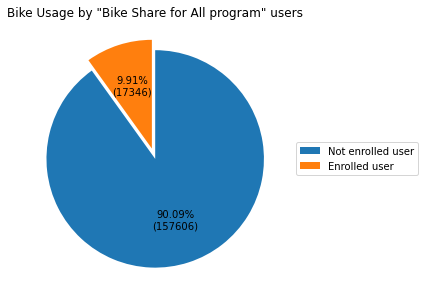

In [24]:
#sb.countplot(data=df,x='bike_share_for_all_trip')
#plt.title('Usage by "Bike Share for All program" users');

plt.figure(figsize=[12,5])
x_label=['Not enrolled user','Enrolled user']
#x_order=['Yes','No']
explode = (0,0.1) 

sorted_count=df['bike_share_for_all_trip'].value_counts()

plt.pie(sorted_count,labels=None,startangle=90, explode=explode,\
        autopct=lambda p:'{:.2f}%\n({:.0f})'.format(p,(p/100)*sorted_count.sum()),counterclock=False)

plt.title('Bike Usage by "Bike Share for All program" users')
plt.legend(x_label,bbox_to_anchor = (1, 0.5), loc = 6)
plt.axis('off');

> Roughly about 10% of trips were made by Bike Share for All program enrolled users.

> ### 1.7 Distribution of Ride Duration
> Next, I will look for distribution of duration of bike trips.
> When I have plotted the histogram, I found that most of data lies under 10000 sec. To better ovserve this range, I have just cut the graph little over mean+3std(6000 sec, 100 min). 

In [25]:
df['duration_min'].describe()

count    174952.000000
mean         11.733379
std          27.370082
min           1.016667
25%           5.383333
50%           8.500000
75%          13.150000
max        1409.133333
Name: duration_min, dtype: float64

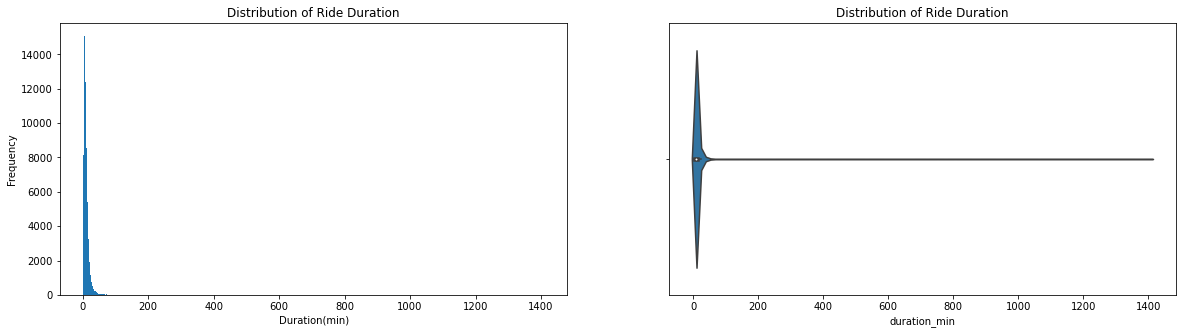

In [26]:
#Define the Figure Size
plt.figure(figsize=[20,5])

plt.subplot(1, 2, 1)
bins=np.arange(df.duration_min.min(),df.duration_min.max()+1,1)
plt.hist(df.duration_min,bins=bins);
plt.xlabel('Duration(min)')
plt.ylabel('Frequency')
plt.title('Distribution of Ride Duration');


plt.subplot(1, 2, 2)
sb.violinplot(data=df,x='duration_min')
plt.title('Distribution of Ride Duration');


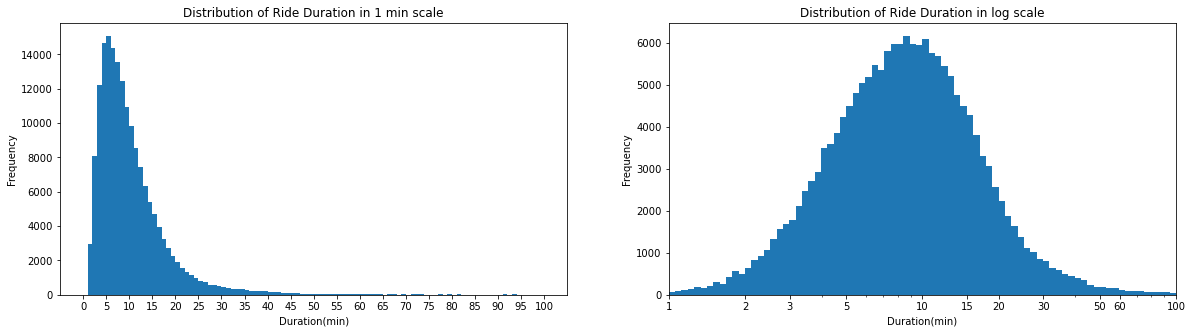

In [27]:
#Define the Figure Size
plt.figure(figsize=[20,5])

#Bin size=1 min
plt.subplot(1, 2, 1)
bins=np.arange(0,100+1,1)
x_ticks=np.arange(0,100+5,5)
plt.hist(df.duration_min,bins=bins)
plt.xticks(x_ticks, x_ticks)
plt.xlabel('Duration(min)')
plt.ylabel('Frequency')
plt.title('Distribution of Ride Duration in 1 min scale')

#Bin size in log scale
plt.subplot(1, 2, 2)
log_binsize=0.025
bins = 10 ** np.arange(0, np.log10(df.duration_min.max())+log_binsize, log_binsize)
x_ticks=[1,2,3,5,10,15,20,30,50,60,100]
plt.hist(df.duration_min,bins=bins);
plt.xscale('log')
plt.xticks(x_ticks, x_ticks);
plt.xlabel('Duration(min)')
plt.ylabel('Frequency')
plt.title('Distribution of Ride Duration in log scale')
plt.xlim(1,100);



> Most of rides are below 60 minutes and approximately 99% of trips were made under these time range. The distribution is heavily skewed to the right showing that most bikes are generally used for short trips.  


> ### 1.8 Distribution of start and end station distance 
> Even if the start and end position cannot represent absolute travel distances, I just tried to see how far apart between the start and end bike stand. 

In [28]:
df.dist.describe()

count    174952.000000
mean          1.690051
std           1.096958
min           0.000000
25%           0.910444
50%           1.429831
75%           2.224013
max          69.469337
Name: dist, dtype: float64

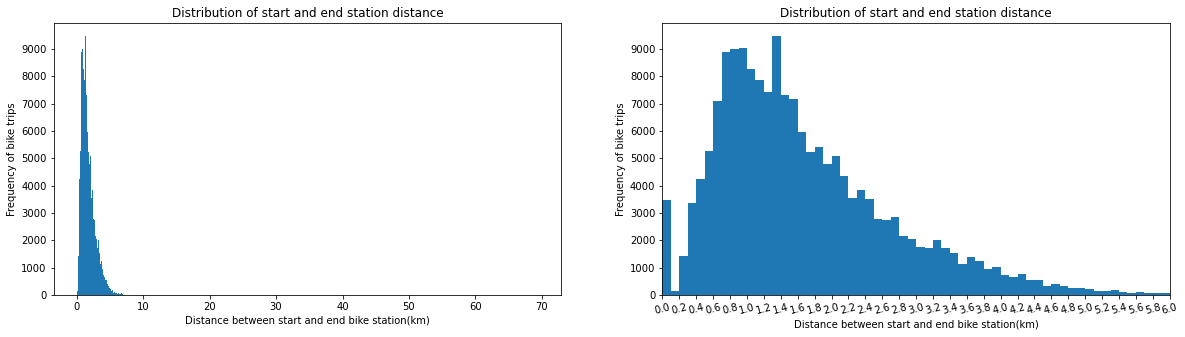

In [29]:
plt.figure(figsize=[20,5])

plt.subplot(1,2,1)
bins=np.arange(0, df.dist.max(), 0.1)
plt.hist(df.dist,bins)
plt.yticks(np.arange(0,10000,1000),np.arange(0,10000,1000))
plt.xlabel('Distance between start and end bike station(km)')
plt.ylabel('Frequency of bike trips')
plt.title("Distribution of start and end station distance")


plt.subplot(1,2,2)
bins=np.arange(0, df.dist.max(), 0.1)
plt.hist(df.dist,bins)
plt.xticks(np.around(np.arange(0,6+0.2,0.2),decimals=1),np.around(np.arange(0,6+0.2,0.2),decimals=1))
plt.xticks(rotation=15)
plt.yticks(np.arange(0,10000,1000),np.arange(0,10000,1000))
plt.xlabel('Distance between start and end bike station(km)')
plt.ylabel('Frequency of bike trips')
plt.title("Distribution of start and end station distance")
plt.xlim(0,6);

> It seems that distance between start and end bike stations are under few kilimeters(~3 km) range. Distance under few hundreds meters may represent round trip made by bike users. 

In [30]:
#df[df['dist']<0.2].dist.count()

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Age data contained value over 100, showing max value of 148 which is very unlikely. So I have plotted ages under 80 which has some meaningful frequency values(>100). 
> The distance between start and end time had one large outlier so I have limited our observation to 6 km.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?
> Bike share duration in sec had unusually large value data (84548, +23 hours) while most of data lied under 60 minutes duration. When I plotted histogram in minute scale between 0~100 minute, I have also observed that the graph is right skewed. So I have tried to plot graph in log scale and then I was able to see normally distributed graph.


### Data Cleansing
> Considering the observation from the univariate exploration, I decided to drop out extrem values before I proceed bivariate & multivariate exploration

In [31]:
df_clean=df.copy()
df_clean=df_clean[df_clean['age']<80]
df_clean = df_clean[df_clean['duration_min']<100]
df_clean=df_clean[df_clean['dist']<6]
df_clean.reset_index(inplace=True,drop=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173347 entries, 0 to 173346
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             173347 non-null  int64         
 1   start_time               173347 non-null  datetime64[ns]
 2   end_time                 173347 non-null  datetime64[ns]
 3   start_station_id         173347 non-null  category      
 4   start_station_name       173347 non-null  object        
 5   start_station_latitude   173347 non-null  float64       
 6   start_station_longitude  173347 non-null  float64       
 7   end_station_id           173347 non-null  category      
 8   end_station_name         173347 non-null  object        
 9   end_station_latitude     173347 non-null  float64       
 10  end_station_longitude    173347 non-null  float64       
 11  bike_id                  173347 non-null  int64         
 12  user_type       

## Bivariate Exploration

> In this section, I will investigate relationships between pairs of variables by plotting correlations present between features.

In [32]:
numeric_vars = ['age','duration_min','dist']
categoric_vars = ['hour','weekday','member_gender','user_type','bike_share_for_all_trip']

<Figure size 576x216 with 0 Axes>

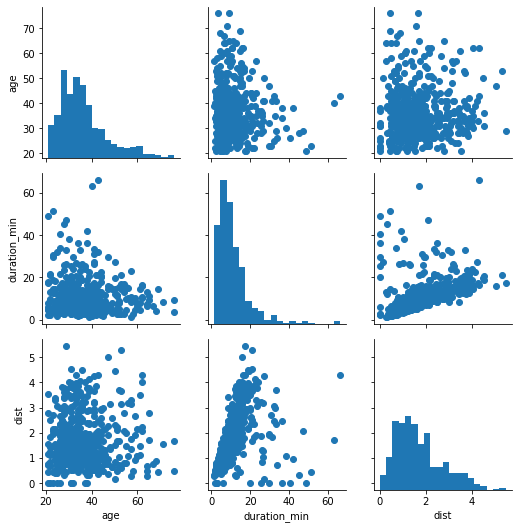

In [33]:
# plot matrix: sample 500 diamonds so that plots are clearer and
# they render faster
plt.figure(figsize=[8,3]);
samples = np.random.choice(df_clean.shape[0], 500, replace = False)
samp = df_clean.loc[samples,:]

g = sb.PairGrid(data = samp, vars = numeric_vars);
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter);

> - Duration of bike ride and Distance between start & end station has high relationship .
> - There is no significant relation between bike ride time and age or distance and age. 
> - To see if there are hidden relation in log scale of duration_min, I have plotted duration min and age in log scale. 

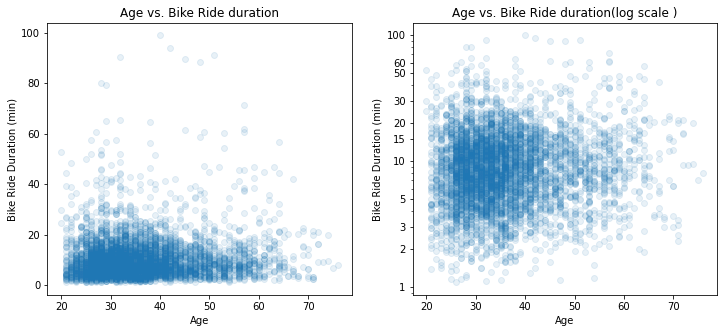

In [34]:
#Plot only samples from oneway trip, since we cannot get information about distance in round trip case

#df_ot=df_clean[df_clean['oneway_trip']==1]
#df_ot.reset_index(drop=True,inplace=True)

samples = np.random.choice(df_clean.shape[0], 5000, replace = False)
samp = df_clean.loc[samples,:]


# scatter plot of duration_min vs. member_age, with log transform on duration_min axis
plt.figure(figsize = [12, 5]);
plt.subplot(1,2,1)
plt.scatter(data = samp, x = 'age', y = 'duration_min', alpha = 1/10);
plt.xlabel('Age');
plt.ylabel('Bike Ride Duration (min)');
plt.title('Age vs. Bike Ride duration')

plt.subplot(1,2,2)

plt.scatter(data = samp, x = 'age', y = 'duration_min', alpha = 1/10);
plt.xlabel('Age');
plt.yscale('log');
plt.yticks([1,2,3,5,10,15,20,30,50,60,100], [1,2,3,5,10,15,20,30,50,60,100]);
plt.ylabel('Bike Ride Duration (min)');
plt.title('Age vs. Bike Ride duration(log scale )');

> - I was not able to find relation between age and bike duration even in log scale.

> Here I will take a look on duration,age,dist on the 5 categorical variables: hour, weekday, gender, user type, bike-share-all user.

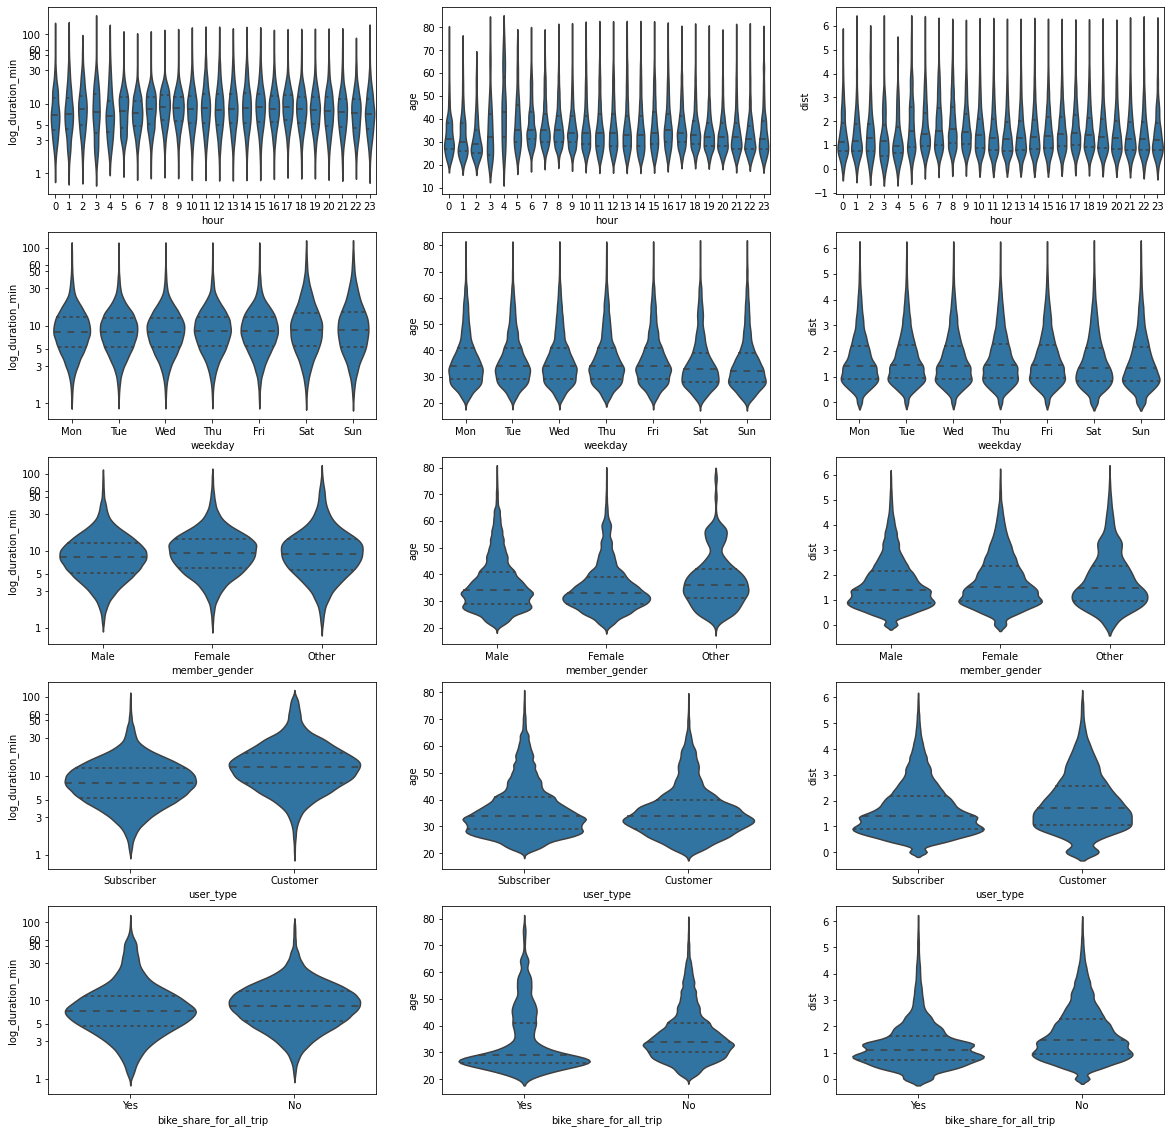

In [35]:
# plot the categorical variables against duration_min,age,dist  and carat again, this time
# with full data and variable transforms

def log_trans(x, inverse = False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

df_clean['log_duration_min'] = df_clean['duration_min'].apply(log_trans)

fig, ax = plt.subplots(ncols = 3, nrows = 5 , figsize = [20,20])
default_color = sb.color_palette()[0]
for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    sb.violinplot(data = df_clean, x = var, y = 'log_duration_min', ax = ax[i,0], color = default_color,inner='quartile');
    ax[i,0].set_yticks(log_trans(np.array([1,3,5,10,30,50,60,100])));
    ax[i,0].set_yticklabels([1,3,5,10,30,50,60,100]);
    sb.violinplot(data = df_clean, x = var, y = 'age', ax = ax[i,1], color = default_color,inner='quartile' );
    sb.violinplot(data = df_clean, x = var, y = 'dist', ax = ax[i,2], color = default_color,inner='quartile');




> - Log transformation of bike ride duration made the values distributed evenly over mean of 10 minutes.
> - Around 4AM the mean age of user is higher than any other time ranges. 
> - During weekends the bike ride duations are dispersed more widely than weekdays.
> - Subscribers tend to use bike for shorter trips than non-subcribers. 75% of subscribers's bike time was less than 10 minutes while that of non-subscribers were 20 minutes.
> - Similarily travel distances for non-subscribers were slightly longer than subscribers. 75% of subscribers used bike for under 2.5km trips while 75% of non-subscribers used bike for less than 3 km trips. 
> - Users who applied for bike share for all proram are younger than regular users.  Almost 50% of the program enrolled users were younger than 30 years old. 
> - Users who signed up for bike share for all program has extremply high density around 30 and skewed to lower ages.


Here I will plot relation between categorical features and differnet time scale (hour and weekday) 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


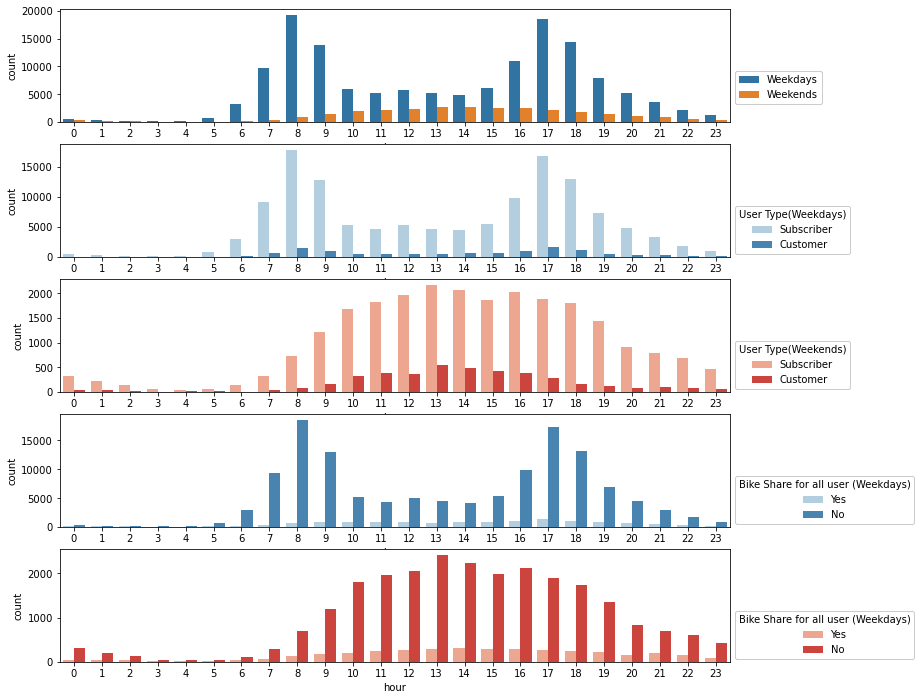

In [36]:
# since there's only three subplots to create, using the full data should be fine.
plt.figure(figsize = [12, 12])
           
#subplot 1: hourly usage on weekdays and weekends
ax = plt.subplot(5, 1, 1);
cat2_label=["Weekdays","Weekends"]
sb.countplot(data = df_clean, x = 'hour', hue = 'is_weekend');
ax.legend(ncol = 2); # re-arrange legend to reduce overlapping
plt.legend(cat2_label, framealpha = 1,bbox_to_anchor = (1, 0.5));


#subplot 2:  hourly usage by subcribers & non-subscribersn on weekdays
ax = plt.subplot(5, 1, 2);

sb.countplot(data = df_clean[df.is_weekend==0], x = 'hour', hue = 'user_type', palette = 'Blues');
ax.legend(loc = 1, ncol = 2); # re-arrange legend to remove overlapping
plt.legend(title='User Type(Weekdays)',framealpha = 1,bbox_to_anchor = (1, 0.5));

#subplot 3:  hourly usage by subcribers & non-subscribers on weekends
ax = plt.subplot(5, 1, 3);

sb.countplot(data = df_clean[df.is_weekend==1], x = 'hour', hue = 'user_type', palette = 'Reds');
ax.legend(loc = 1, ncol = 2); # re-arrange legend to remove overlapping
plt.legend(title='User Type(Weekends)',framealpha = 1,bbox_to_anchor = (1, 0.5));

#subplot 4:  hourly usage by bikeshare all users on weekdays
ax = plt.subplot(5, 1, 4);

sb.countplot(data = df_clean[df.is_weekend==0], x = 'hour', hue = 'bike_share_for_all_trip', palette = 'Blues');
ax.legend(loc = 1, ncol = 2); # re-arrange legend to remove overlapping
plt.legend(title='Bike Share for all user (Weekdays)',framealpha = 1,bbox_to_anchor = (1, 0.5));

#subplot 5:  hourly usage by bikeshare all users on weekends
ax = plt.subplot(5, 1, 5);
sb.countplot(data = df_clean[df.is_weekend==1], x = 'hour', hue = 'bike_share_for_all_trip',hue_order=["Yes","No"], palette = 'Reds');
ax.legend(loc = 1, ncol = 2); # re-arrange legend to remove overlapping
plt.legend(title='Bike Share for all user (Weekdays)',framealpha = 1,bbox_to_anchor = (1, 0.5));



> - During Weekday, the plot has shape of bimodal curve with peaks at 8 AM and 5 PM showing that bike trip frequency matches with commuter time. However, during weekends the peak hours are around noon and has relatively flat usage pattern between 10 AM and 6 PM.
> - There are no significant difference in subscriber and non-subscriber usage pattern in a hourly pattern. 
> - Hourly usage by Bike Share all program users are relatively constant over 8am to 8PM regardless of weekdays or weekends. 

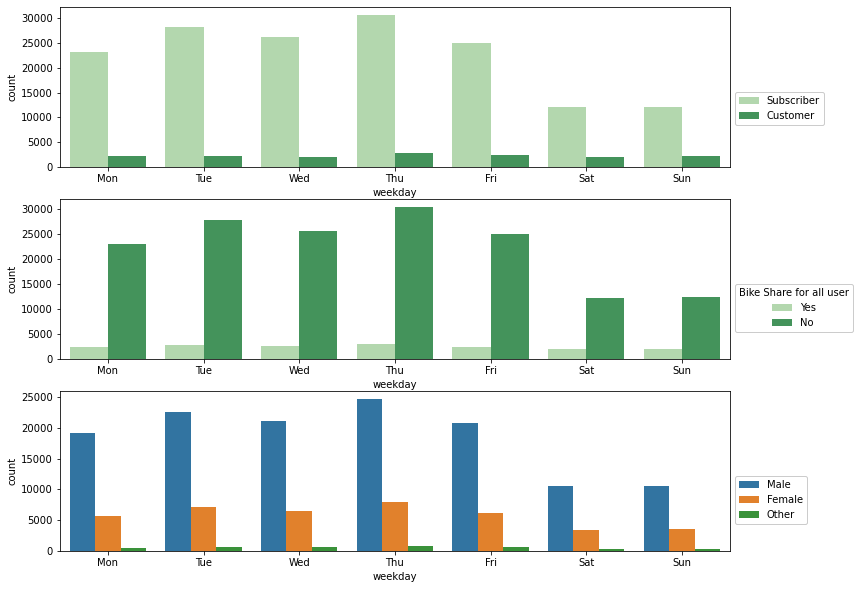

In [37]:
plt.figure(figsize = [12, 10])

#subplot 1: weekly usage by subscribers & non-subscribers
ax = plt.subplot(3, 1, 1);
sb.countplot(data = df_clean, x = 'weekday', hue = 'user_type', palette = 'Greens');
ax.legend(loc = 1, ncol = 2); # re-arrange legend to remove overlapping  
plt.legend(framealpha = 1,bbox_to_anchor = (1, 0.5)); 

#subplot 2: weekly usage by bike share for all program applicant

ax = plt.subplot(3, 1, 2);
sb.countplot(data = df_clean, x = 'weekday', hue = 'bike_share_for_all_trip', palette = 'Greens');        
ax.legend(loc = 1, ncol = 2)
plt.legend(title="Bike Share for all user",framealpha = 1,bbox_to_anchor = (1, 0.5));  
           
           
ax = plt.subplot(3, 1, 3);
sb.countplot(data = df_clean, x = 'weekday', hue = 'member_gender');
ax.legend(loc = 1, ncol = 2);
plt.legend(framealpha = 1,bbox_to_anchor = (1, 0.5)); 
    

> While the customer portions seems to increase during weekend, I was not able to see relation in current scale I plotted stacked bar for Usage pattern by user_type for each weekday.

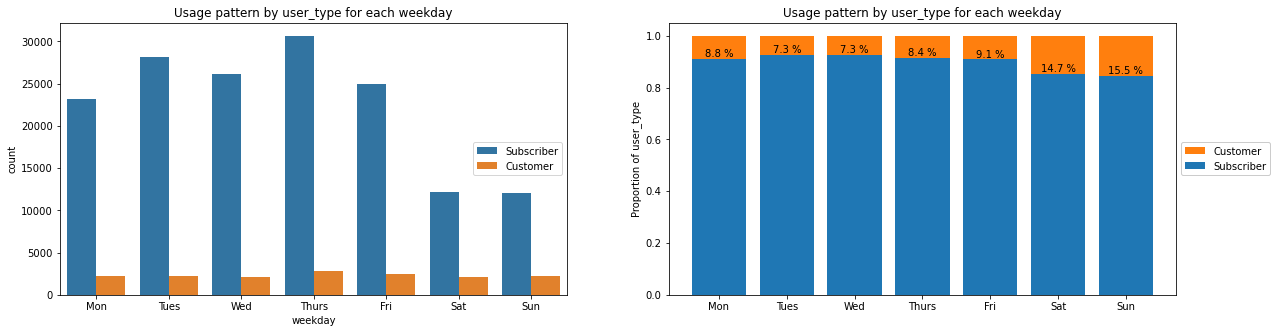

In [38]:
plt.figure(figsize=[20,5])

cat1_label = ['Mon', 'Tues', 'Wed', 'Thurs','Fri','Sat','Sun']
cat2_label = ['Subscriber', 'Customer']

##########################################
plt.subplot(1,2,1)
sb.countplot(data=df_clean,x='weekday',hue='user_type')
plt.xticks(np.arange(0,7),cat1_label)
plt.legend(cat2_label,loc=5); 
plt.title("Usage pattern by user_type for each weekday")

#########################################
plt.subplot(1,2,2)
bikes_count = []# for storing references to plot elements
baselines = np.zeros(len(cat1_label))
cat1_counts = df_clean.groupby('weekday')['weekday'].count()


for i in range(len(cat2_label)):
    cat2 = cat2_label[i]
    inner_counts = df_clean[df_clean['user_type'] == cat2].groupby('weekday')['weekday'].count()   
    inner_props = inner_counts / cat1_counts
    bars = plt.bar(x = np.arange(len(cat1_label)),
                   height = inner_props,
                   bottom = baselines)
    
    bikes_count.append(bars)
    baselines += inner_props

plt.xticks(np.arange(len(cat1_label)), cat1_label)
plt.ylabel("Proportion of user_type")
plt.title("Usage pattern by user_type for each weekday")
plt.legend(reversed(bikes_count), reversed(cat2_label), framealpha = 1,
           bbox_to_anchor = (1, 0.5), loc = 6)
for x,y in zip(range(7),inner_props):
    label = "{:.1f} %".format(y*100)
    plt.annotate(label, # this is the text
                 (x,1-y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,2), # distance from text to points (x,y)
                 ha='center') ;# horizontal alignment can be left, right or cent

> During weekends there are slight increase in proportion of usage by non-subscribers, who might try out bike trip for leisure purpose.

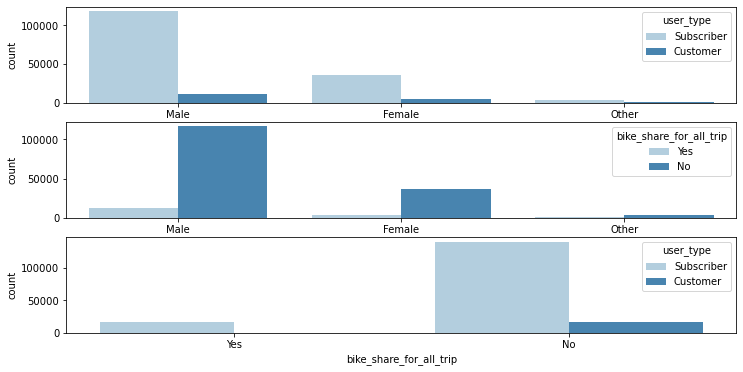

In [39]:
plt.figure(figsize = [12, 6])

#hour weekday
#dist duration_min age gender,user_type,bike_share_for_all
           

#subplot 1: hourly usage on different day of week
plt.subplot(3, 1, 1)
sb.countplot(data = df_clean, x = 'member_gender', hue = 'user_type',palette='Blues');


#subplot 2: hourly usage on weekdays and weekends
ax = plt.subplot(3, 1, 2);
sb.countplot(data = df_clean, x = 'member_gender', hue = 'bike_share_for_all_trip',palette='Blues');

#subplot 3:  hourly usage by subcribers & non-subscribers
ax = plt.subplot(3, 1, 3);
sb.countplot(data = df_clean, x = 'bike_share_for_all_trip', hue = 'user_type', palette = 'Blues');


 > - Bike share for all trip users are all subscribers.
 > - It looks like that Non-Subscriber portion of users are slighly larger in male than that of female. To see clearly this pattern, I created a stacked bar chart. 

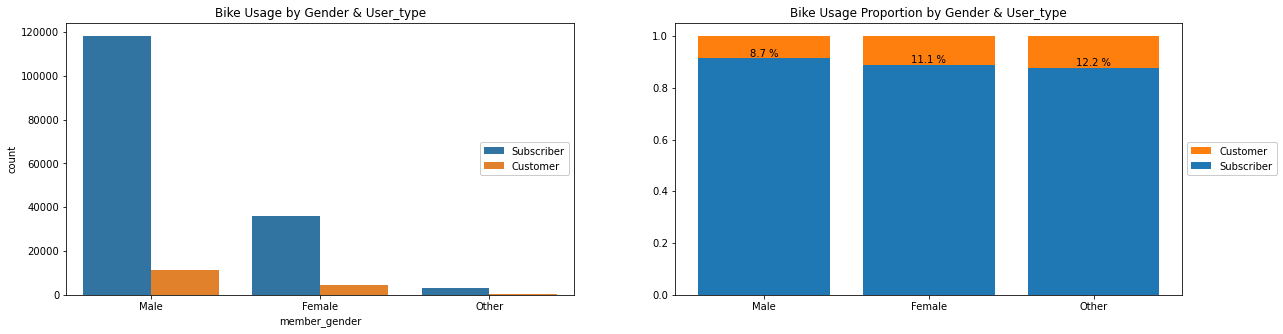

In [40]:
plt.figure(figsize=[20,5])
cat1_order=["Male","Female","Other"]
cat2_order = ['Subscriber', 'Customer']


##########################################
plt.subplot(1,2,1)
sb.countplot(data=df_clean,x='member_gender',hue='user_type')
plt.legend(framealpha = 1,bbox_to_anchor = (1, 0.5), loc = 5)
plt.title("Bike Usage by Gender & User_type")
##########################################
plt.subplot(1,2,2)
bikes_count = []# for storing references to plot elements
baselines = np.zeros(len(cat1_order))
cat1_counts = df_clean['member_gender'].value_counts()

for i in range(len(cat2_order)):
    cat2 = cat2_order[i]
    inner_counts = df_clean[df_clean['user_type'] == cat2]['member_gender'].value_counts() 
    inner_props = inner_counts / cat1_counts
    bars = plt.bar(x = np.arange(len(cat1_order)),
                   height = inner_props,
                   bottom = baselines)
    
    bikes_count.append(bars)
    baselines += inner_props

plt.xticks(np.arange(len(cat1_order)), cat1_order)
plt.title("Bike Usage Proportion by Gender & User_type")
plt.legend(reversed(bikes_count), reversed(cat2_order), framealpha = 1,
           bbox_to_anchor = (1, 0.5), loc = 6)

for x,y in zip(range(3),inner_props):
    label = "{:.1f} %".format(y*100)
    plt.annotate(label, # this is the text
                 (x,1-y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,2), # distance from text to points (x,y)
                 ha='center') ;# horizontal alignment can be left, right or center;

> Non-Subscriber portion of users are slightly higher in male than that of female.  

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> - Even though I had doubt that distance between start end position could tell about the user travel distances (since the direct distance can be different and users can make round trips) I was able to see high correlation between duration of bike ride and distance between start & end station. From there I was able to get slope which later can be used for average speed of bike ride.
> -  Subscribers tend to use bike for shorter trips than non-subcribers. 75% of subscribers's bike time was less than 10 minutes while that of non-subscribers were 20 minutes.
> - Similarly travel distances for non-subscribers were slightly longer than subscribers. 75% of subscribers used bike for under 2.5km trips while 75% of non-subscribers used bike for less than 3 km trips. 
> - Users who applied for bike share for all program are younger than regular users.  Almost 50% of the program enrolled users were younger than 30 years old. 
> - During weekends the bike ride duations are dispersed more widely than weekdays. 
> - Hourly usage by Bike Share all program users are relatively constant over 8am to 8PM regardless of weekdays or weekends. 
> - By carefully creating stacked bar chart, I was able to see that non-Subscriber portion of users are slightly(2.4%) larger in male than that of female.
> - During weekends there is slight increase in proportion of usage by non-subscribers, who might try out bike trip for leisure purpose.


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> By plotting hourly usage by day of weeks(monday to sunday), I found that the pattern during weekdays and weekends are different. So I have created column grouping weekdays and weekends for further analysis. During Weekday, the plot has shape of bimodal curve with peaks at 8 AM and 5 PM showing that bike trip frequency matches with commuter time. However, during weekends the peak hours are around noon and has relatively flat usage pattern between 10 AM and 6 PM.


## Multivariate Exploration

> The main thing I want to explore in this part of the analysis is how the categorical measures play into the relationship between age & duration.
- age x duration x week
- age x duration x gender
- age x duration x user_type
- age x duration x bike_share_for_all

In [41]:

def hist2dgrid(x, y, **kwargs):
    """ Quick hack for creating heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color');
    bins_x = np.arange(20,90,2);
    bins_y = np.arange(0, 2, 0.1);
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 0.5);
    plt.xticks(np.arange(20,90,10),np.arange(20,90,10))
    plt.yticks(log_trans(np.array([1, 2,3, 5, 10,15, 20,30, 40,50, 100])),
               [1, 2, 3, 5, 10,15, 20,30,40,50, 100]);

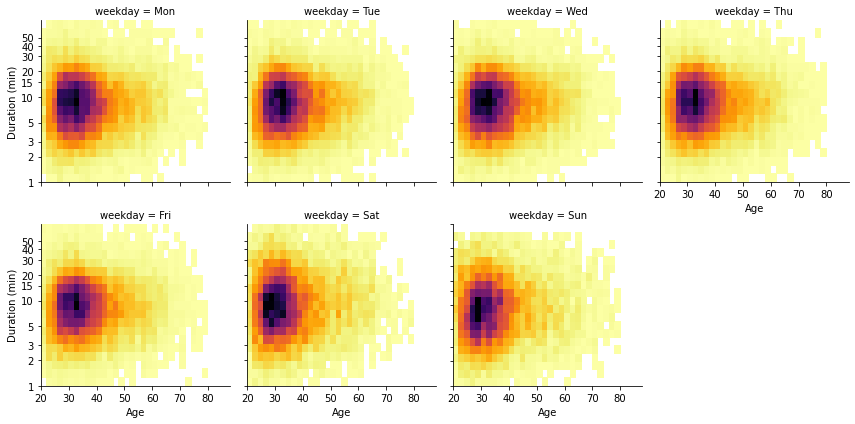

In [42]:
# create faceted heat maps 
g = sb.FacetGrid(data = df_clean, col = 'weekday', col_wrap = 4, height = 3);
g.map(hist2dgrid, 'age', 'log_duration_min', color = 'inferno_r');
g.set_xlabels('Age');
g.set_ylabels('Duration (min)');

> - People take longer bike trip during weekends.

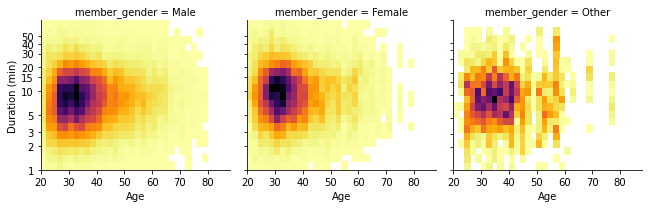

In [43]:
# create faceted heat maps 
g = sb.FacetGrid(data = df_clean, col = 'member_gender', col_wrap = 4, height = 3);
g.map(hist2dgrid, 'age', 'log_duration_min', color = 'inferno_r');
g.set_xlabels('Age');
g.set_ylabels('Duration (min)');

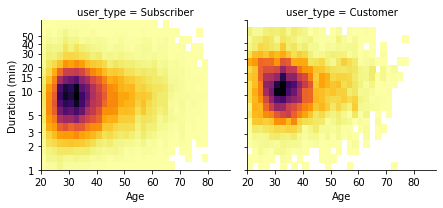

In [44]:
# create faceted heat maps 
g = sb.FacetGrid(data = df_clean, col = 'user_type', col_wrap = 4, height = 3);
g.map(hist2dgrid, 'age', 'log_duration_min', color = 'inferno_r');
g.set_xlabels('Age');
g.set_ylabels('Duration (min)');

> Non Subscriber('Customer') bikers bike longer on average compared to Subscribers

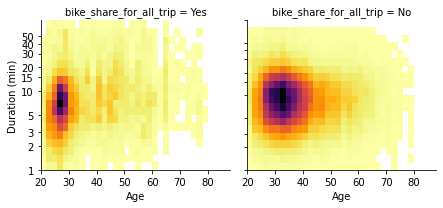

In [45]:
# create faceted heat maps on duration vs. age
g = sb.FacetGrid(data = df_clean, col = 'bike_share_for_all_trip', col_wrap = 4, height = 3);
g.map(hist2dgrid, 'age', 'log_duration_min', color = 'inferno_r');
g.set_xlabels('Age');
g.set_ylabels('Duration (min)');

> - Similar info as observation in bivarite exploration
> - Bike Share for All program enrolled users are highly populated around 20~30 yers and younger than non-program users

> Here I will investigate more dividing user groups into 2 and days of week into 2
> - Users greater than 40 years old and younger than 40s.
> - Weekdays and Weekends

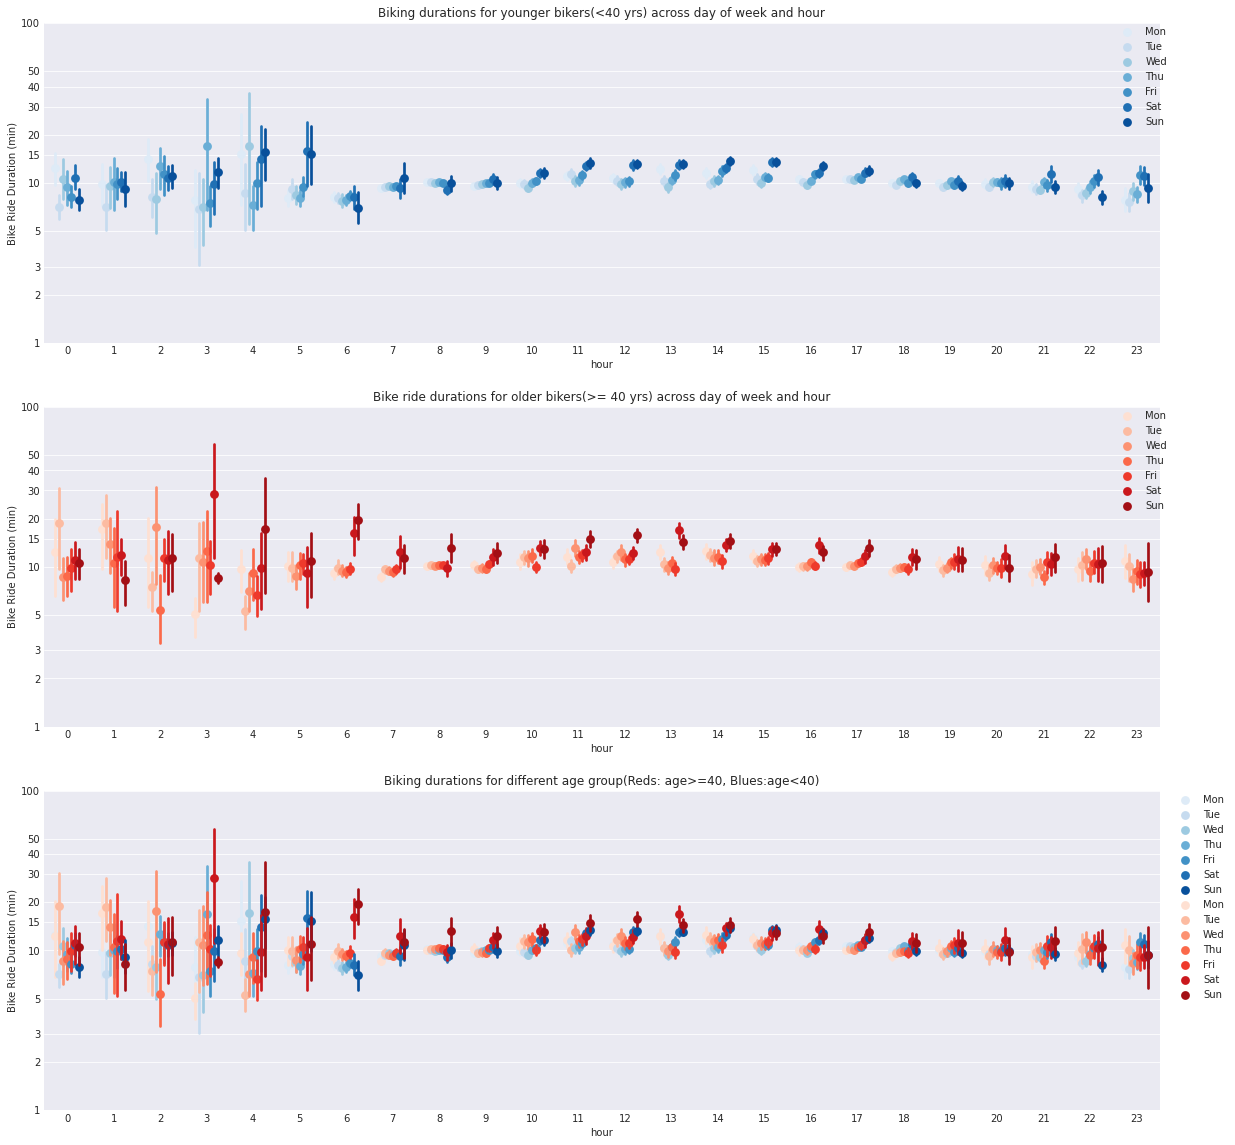

In [46]:
plt.style.use("seaborn-darkgrid")
fig = plt.figure(figsize = [20,20])

plt.subplot(3,1,1)
ax = sb.pointplot(data = df_clean[df_clean.age<40], x = 'hour', y = 'duration_min', hue = 'weekday',
           palette = 'Blues', linestyles = '', dodge = 0.5);

plt.title('Biking durations for younger bikers(<40 yrs) across day of week and hour');
plt.ylabel('Bike Ride Duration (min)');
plt.yscale('log');
plt.yticks([1, 2,3, 5, 10,15, 20,30, 40,50, 100], [1, 2,3, 5, 10,15, 20,30, 40,50, 100]);
ax.set_yticklabels([],minor = True);
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


plt.subplot(3,1,2)
ax = sb.pointplot(data = df_clean[df_clean.age>=40], x = 'hour', y = 'duration_min', hue = 'weekday',
           palette = 'Reds', linestyles = '', dodge = 0.5);

plt.title('Bike ride durations for older bikers(>= 40 yrs) across day of week and hour');
plt.ylabel('Bike Ride Duration (min)');
plt.yscale('log');
plt.yticks([1, 2,3, 5, 10,15, 20,30, 40,50, 100], [1, 2,3, 5, 10,15, 20,30, 40,50, 100]);
ax.set_yticklabels([],minor = True);
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.subplot(3,1,3)
ax = sb.pointplot(data = df_clean[df_clean.age<40], x = 'hour', y = 'duration_min', hue = 'weekday',
           palette = 'Blues', linestyles = '', dodge = 0.5,legend_out=None);
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0);
ax = sb.pointplot(data = df_clean[df_clean.age>=40], x = 'hour', y = 'duration_min', hue = 'weekday',
           palette = 'Reds', linestyles = '', dodge = 0.5,legend_out=None);
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0);
plt.title('Biking durations for different age group(Reds: age>=40, Blues:age<40)');
plt.ylabel('Bike Ride Duration (min)');
plt.yscale('log');
plt.yticks([1, 2,3, 5, 10,15, 20,30, 40,50, 100], [1, 2,3, 5, 10,15, 20,30, 40,50, 100]);
ax.set_yticklabels([],minor = True);
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0);


> - Older Age group(> 40s yrs old)" rides longer duration than younger groups
> - At around 2~5 AM, range of bike ride duration are widely distributed while the bike ride time is concentratd around 10 ~15 minutes.
> - Bike ride times are longer on Saturday and Sunday than weekdays.

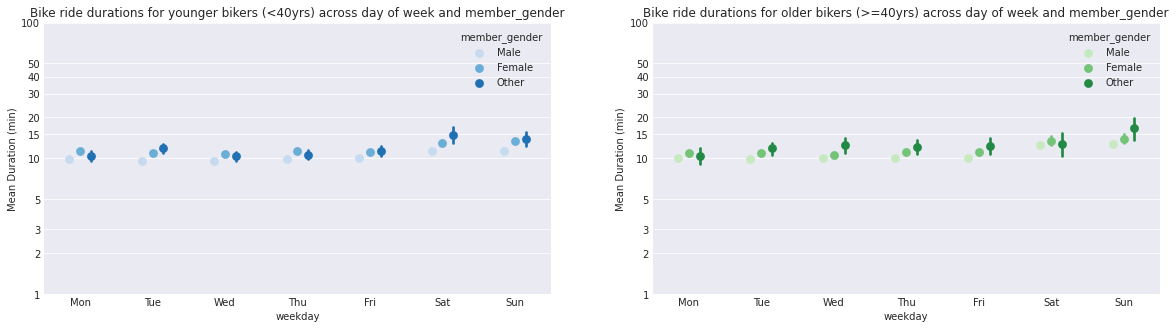

In [47]:
fig = plt.figure(figsize = [20,5])
plt.subplot(1,2,1)

ax = sb.pointplot(data = df_clean[df_clean.age<40], x = 'weekday', y = 'duration_min', hue = 'member_gender',
           hue_order=["Male","Female","Other"],palette = 'Blues', linestyles = '', dodge = 0.3);
plt.title('Bike ride durations for younger bikers (<40yrs) across day of week and member_gender');
plt.ylabel('Mean Duration (min)')
plt.yscale('log');
plt.yticks([1, 2,3, 5, 10,15, 20,30, 40,50, 100], [1, 2,3, 5, 10,15, 20,30, 40,50, 100]);
ax.set_yticklabels([],minor = True);

plt.subplot(1,2,2)

ax = sb.pointplot(data = df_clean[df_clean.age>=40], x = 'weekday', y = 'duration_min', 
                  hue = 'member_gender',
           palette = 'Greens', linestyles = '', dodge = 0.3);
plt.title('Bike ride durations for older bikers (>=40yrs) across day of week and member_gender');
plt.ylabel('Mean Duration (min)')
plt.yscale('log');
plt.yticks([1, 2,3, 5, 10,15, 20,30, 40,50, 100], [1, 2,3, 5, 10,15, 20,30, 40,50, 100]);
ax.set_yticklabels([],minor = True);

> No significant differences of gender and agegroup in their riding time over different days of a week.

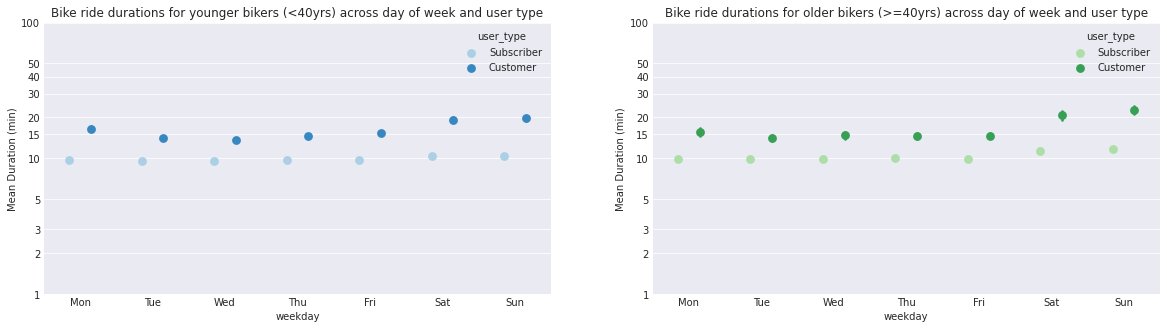

In [48]:
fig = plt.figure(figsize = [20,5])
plt.subplot(1,2,1)

ax = sb.pointplot(data = df_clean[df_clean.age<40], x = 'weekday', y = 'duration_min', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.3);
plt.title('Bike ride durations for younger bikers (<40yrs) across day of week and user type');
plt.ylabel('Mean Duration (min)')
plt.yscale('log');
plt.yticks([1, 2,3, 5, 10,15, 20,30, 40,50, 100], [1, 2,3, 5, 10,15, 20,30, 40,50, 100]);
ax.set_yticklabels([],minor = True);

plt.subplot(1,2,2)

ax = sb.pointplot(data = df_clean[df_clean.age>=40], x = 'weekday', y = 'duration_min', hue = 'user_type',
           palette = 'Greens', linestyles = '', dodge = 0.3);
plt.title('Bike ride durations for older bikers (>=40yrs) across day of week and user type');
plt.ylabel('Mean Duration (min)')
plt.yscale('log');
plt.yticks([1, 2,3, 5, 10,15, 20,30, 40,50, 100], [1, 2,3, 5, 10,15, 20,30, 40,50, 100]);
ax.set_yticklabels([],minor = True);


 > Average subscribers' ride time is shorter than that of non-subscribers regardless of age group

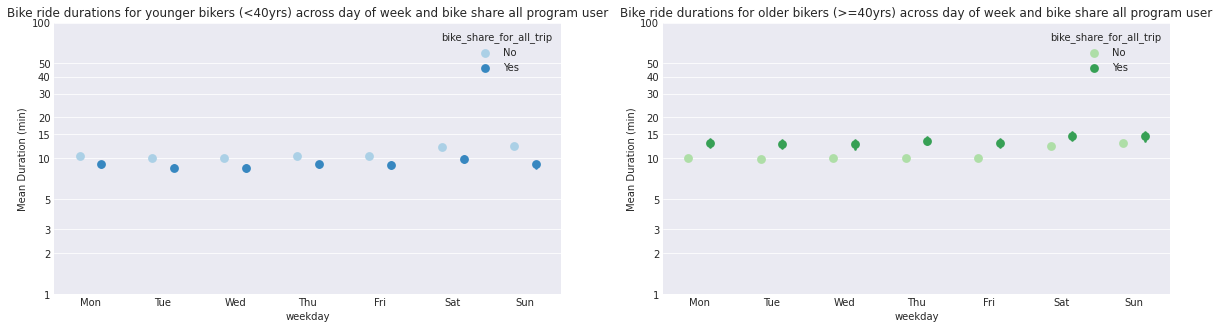

In [49]:
fig = plt.figure(figsize = [20,5])
plt.subplot(1,2,1)

ax = sb.pointplot(data = df_clean[df_clean.age<40], x = 'weekday', y = 'duration_min', hue = 'bike_share_for_all_trip',
           palette = 'Blues', linestyles = '', dodge = 0.3);
plt.title('Bike ride durations for younger bikers (<40yrs) across day of week and bike share all program user');
plt.ylabel('Mean Duration (min)')
plt.yscale('log');
plt.yticks([1, 2,3, 5, 10,15, 20,30, 40,50, 100], [1, 2,3, 5, 10,15, 20,30, 40,50, 100]);
ax.set_yticklabels([],minor = True);

plt.subplot(1,2,2)

ax = sb.pointplot(data = df_clean[df_clean.age>=40], x = 'weekday', y = 'duration_min', 
                  hue = 'bike_share_for_all_trip', hue_order=["No","Yes"],
           palette = 'Greens', linestyles = '', dodge = 0.3);
plt.title('Bike ride durations for older bikers (>=40yrs) across day of week and bike share all program user');
plt.ylabel('Mean Duration (min)')
plt.yscale('log');
plt.yticks([1, 2,3, 5, 10,15, 20,30, 40,50, 100], [1, 2,3, 5, 10,15, 20,30, 40,50, 100]);
ax.set_yticklabels([],minor = True);

>  Aveg. bike duration for "Bike share for all" program enrolled users is shorter than non-program enrolled users in younger users but it is opposite in older user group.


### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> - Here I have convinced that weekend bike duration is longer. 
> - From 2d heatmap in various categories, I constitenlty obaserved that there was heavy density of users of age between 20~40 and of ride duration of around 5~20 minutes.
> Bike Share for All program enrolled users are highly populated around 20~30 years and this users were younger than non-program users.
> - Riders' gender doen't seem to have impact on bike ride time or distances.
> - On average, subscribers' ride time was shorter than that of non-subscribers regardless of age group.





### Were there any interesting or surprising interactions between features?

> Here I first reconized that there is different bike ride time pattern for different age groups. Older Age group(> 40s yrs old)" rides longer duration than younger groups. "Bike share for all" program enrolled users' Aveg. bike duration was shorter than non-program enrolled users in younger users, while the time was longer for program enrolled users in older users.

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!